# DML ATT Example

This notebook covers scenario:
| Is RCT        | Treatment | Outcome    | EDA | Estimands | Refutation |
|---------------|-----------|------------|-----|-----------|------------|
| Observational | Binary    | Continuous | Yes | ATT       | Yes        |

We will estimate Average Treatment Effect on Treated (ATT) of binary treatment on continuous outcome. It shows explonatary data analysis and refutation tests

## Generate data

Example that generates observational data with a nonlinear outcome model, nonlinear treatment assignment, and a heterogeneous (nonlinear) treatment effect tau(X). This setup ensures that ATT ≠ ATE in general. It also shows how to compute the “ground-truth” ATT from the generated data.

In [1]:
# Nonlinear ATT data generation with heterogeneous effects

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from causalis.data import CausalDatasetGenerator, CausalData

# Reproducibility
np.random.seed(42)

# 1) Confounders and their distributions
#    These names define the column order in X for the custom functions.
confounder_specs = [
    {"name": "tenure_months",     "dist": "normal",   "mu": 24, "sd": 12},
    {"name": "avg_sessions_week", "dist": "normal",   "mu": 5,  "sd": 2},
    {"name": "spend_last_month",  "dist": "uniform",  "a": 0,   "b": 200},
    {"name": "premium_user",      "dist": "bernoulli","p": 0.25},
    {"name": "urban_resident",    "dist": "bernoulli","p": 0.60},
]

# Indices (for convenience inside g_y, g_t, tau)
TENURE, SESS, SPEND, PREMIUM, URBAN = range(5)

# 2) Nonlinear baseline for outcome f_y(X) = X @ beta_y + g_y(X)
#    Keep a modest linear part and add meaningful nonlinearities.
beta_y = np.array([
    0.03,   # tenure_months
    0.20,   # avg_sessions_week
    0.01,   # spend_last_month
    1.20,   # premium_user
    0.60,   # urban_resident
], dtype=float)

def g_y(X: np.ndarray) -> np.ndarray:
    # Nonlinearities and interactions in outcome baseline
    tenure_years = X[:, TENURE] / 12.0
    sessions = X[:, SESS]
    spend = X[:, SPEND]
    premium = X[:, PREMIUM]
    urban = X[:, URBAN]

    return (
        1.2 * np.sin(2.0 * np.pi * tenure_years)          # seasonal-ish tenure pattern
        + 0.02 * (sessions - 5.0) ** 2                    # convex effect of sessions
        + 0.0015 * (spend - 100.0) * (sessions - 5.0)     # spend × sessions interaction
        + 0.4 * premium * (sessions - 5.0)                # premium × sessions interaction
        + 0.3 * urban * np.tanh((spend - 100.0) / 50.0)   # nonlinear spend effect differs by urban
    )

# 3) Nonlinear treatment score f_t(X) = X @ beta_t + g_t(X)
beta_d = np.array([
    0.010,  # tenure_months
    0.12,   # avg_sessions_week
    0.001,  # spend_last_month
    0.80,   # premium_user
    0.25,   # urban_resident
], dtype=float)

def g_d(X: np.ndarray) -> np.ndarray:
    tenure_years = X[:, TENURE] / 12.0
    sessions = X[:, SESS]
    spend = X[:, SPEND]
    premium = X[:, PREMIUM]
    urban = X[:, URBAN]

    # Smoothly increasing selection with spend; interactions make selection non-separable
    soft_spend = 1.2 * np.tanh((spend - 80.0) / 40.0)
    return (
        0.6 * soft_spend
        + 0.15 * (sessions - 5.0) * (tenure_years - 2.0)
        + 0.25 * premium * (urban - 0.5)
    )

# 4) Heterogeneous, nonlinear treatment effect tau(X) on the natural scale (continuous outcome)
def tau_fn(X: np.ndarray) -> np.ndarray:
    tenure_years = X[:, TENURE] / 12.0
    sessions = X[:, SESS]
    spend = X[:, SPEND]
    premium = X[:, PREMIUM]
    urban = X[:, URBAN]

    # Base effect + stronger effect for higher sessions and premium users,
    # diminishes with tenure, mild modulation by spend and urban
    tau = (
        1.0
        + 0.8 * (1.0 / (1.0 + np.exp(-(sessions - 5.0))))    # sigmoid in sessions
        + 0.5 * premium
        - 0.6 * np.clip(tenure_years / 5.0, 0.0, 1.0)        # taper with long tenure
        + 0.2 * urban * (spend - 100.0) / 100.0
    )
    # Optional: keep it in a reasonable range
    return np.clip(tau, 0.2, 2.5)

# 5) Noise and prevalence
sigma_y = 3.5
target_d_rate = 0.35  # enforce ~35% treated via intercept calibration

# 6) Build generator
gen = CausalDatasetGenerator(
    outcome_type="continuous",
    sigma_y=sigma_y,
    target_d_rate=target_d_rate,
    seed=42,
    # Confounders
    confounder_specs=confounder_specs,
    # Outcome/treatment structure
    beta_y=beta_y,
    beta_d=beta_d,
    g_y=g_y,
    g_d=g_d,
    # Heterogeneous effect
    tau=tau_fn,
)

# 7) Generate data (full dataframe includes ground-truth columns: propensity, mu0, mu1, cate)
n = 10000
generated_df = gen.generate(n)

# Ground-truth ATT (on the natural scale): E[tau(X) | T=1] = mean CATE among the treated
true_att = float(generated_df.loc[generated_df["d"] == 1, "cate"].mean())
print(f"Ground-truth ATT from the DGP: {true_att:.3f}")

# 8) Wrap as CausalData for downstream workflows (keeps only y, t, and specified confounders)
causal_data = CausalData(
    df=generated_df,
    treatment="d",
    outcome="y",
    confounders=[
        "tenure_months",
        "avg_sessions_week",
        "spend_last_month",
        "premium_user",
        "urban_resident",
    ],
)

# Peek at the analysis-ready view
causal_data.df.head()

Ground-truth ATT from the DGP: 1.386


,y,d,tenure_months,avg_sessions_week,spend_last_month,premium_user,urban_resident
0,2.237316,0.0,27.656605,5.352554,72.552568,1.0,0.0
1,5.771469,0.0,11.520191,6.798247,188.481287,1.0,0.0
2,6.374653,1.0,33.005414,2.055459,51.040440,0.0,1.0
3,2.364177,1.0,35.286777,4.429404,166.992239,0.0,1.0
4,8.378079,0.0,0.587578,6.658307,179.371126,0.0,0.0


## EDA


In [2]:
from causalis.eda import CausalEDA
eda = CausalEDA(causal_data)

### General dataset information

Let's see how outcome differ between clients who recieved the feature and didn't

In [3]:
# shape of data
eda.data_shape()

{'n_rows': 10000, 'n_columns': 7}

In [4]:
# 1) Outcome statistics by treatment
eda.outcome_stats()

,count,mean,std,min,p10,p25,median,p75,p90,max
treatment,,,,,,,,,,
0.0,6530,3.187197,3.754761,-12.770866,-1.579204,0.699571,3.149215,5.720443,7.931635,17.323664
1.0,3470,5.222463,3.986593,-7.310514,0.151741,2.508651,5.205242,7.975189,10.351169,18.147842


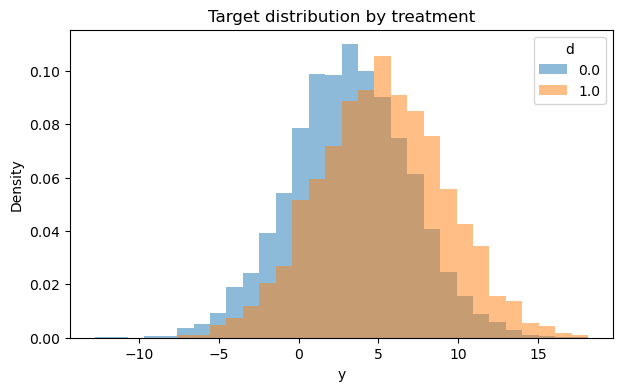

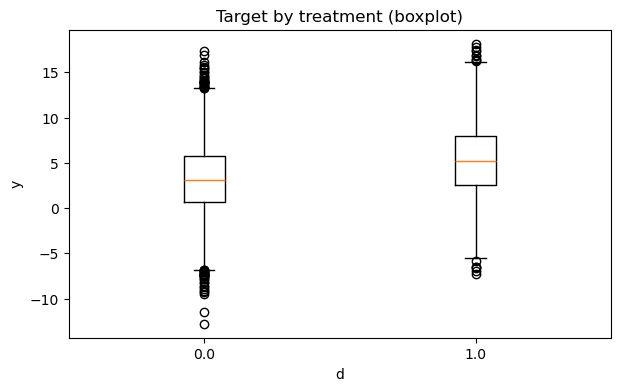

In [5]:
# 2) Outcome distribution by treatment (hist + boxplot)
fig1, fig2 = eda.outcome_plots()
plt.show()

### Propensity

Now let's examine how propensity score differ treatments

In [6]:
# Shows means of confounders for control/treated groups, absolute differences, and SMD values
confounders_balance_df = eda.confounders_means()
display(confounders_balance_df)

,mean_t_0,mean_t_1,abs_diff,smd
confounders,,,,
spend_last_month,90.260494,119.486105,29.225611,0.526811
premium_user,0.194793,0.355043,0.160250,0.364805
avg_sessions_week,4.903763,5.298405,0.394642,0.197681
urban_resident,0.576876,0.646110,0.069234,0.142388
tenure_months,23.336403,24.894323,1.557920,0.129076


In [7]:
# Propensity model fit
ps_model = eda.fit_propensity()

# ROC AUC - shows how predictable treatment is from confounders
roc_auc_score = ps_model.roc_auc
print("ROC AUC from PropensityModel:", round(roc_auc_score, 4))

ROC AUC from PropensityModel: 0.6962


In [8]:
# Positivity check - assess overlap between treatment groups
positivity_result = ps_model.positivity_check()
print("Positivity check from PropensityModel:", positivity_result)

Positivity check from PropensityModel: {'bounds': (0.05, 0.95), 'share_below': 0.0121, 'share_above': 0.0004, 'flag': False}


In [9]:
# SHAP values - feature importance for treatment assignment from confounders
shap_values_df = ps_model.shap
display(shap_values_df)

,feature,shap_mean,shap_mean_abs,odds_mult_abs,exact_pp_change_abs,exact_pp_change_signed
0,num__spend_last_month,-0.000340,0.568471,1.765565,0.136983,-0.000077
1,num__tenure_months,0.000292,0.175348,1.191661,0.040684,0.000066
2,num__premium_user,0.000120,0.349319,1.418102,0.082673,0.000027
3,num__urban_resident,-0.000103,0.169225,1.184386,0.039233,-0.000023
4,num__avg_sessions_week,0.000031,0.230236,1.258897,0.053783,0.000007


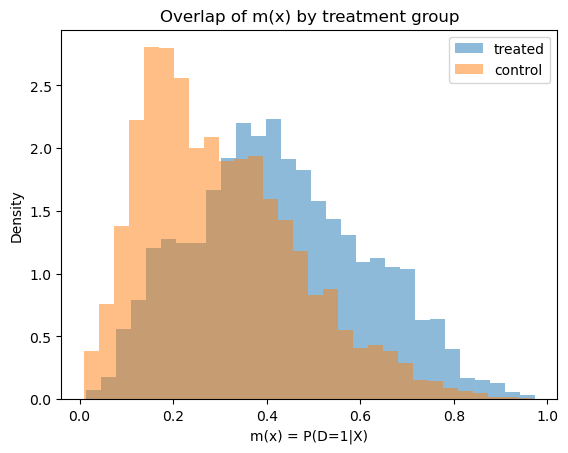

In [10]:
# Propensity score overlap graph
ps_model.ps_graph()
plt.show()

### Outcome regression

Let's analyze how confounders predict outcome

In [11]:
# Outcome model fit
outcome_model = eda.outcome_fit()

# RMSE and MAE of regression model
print(outcome_model.scores)

{'rmse': 3.645288976705851, 'mae': 2.905875481642826}


In [12]:
# 2) SHAP values - feature importance for outcome prediction from confounders
shap_outcome_df = outcome_model.shap
display(shap_outcome_df)

,feature,shap_mean
0,premium_user,0.001576
1,spend_last_month,-0.001158
2,avg_sessions_week,-0.000562
3,urban_resident,0.000089
4,tenure_months,0.000055


# Inference

Now time to estimate ATЕE with Double Machine Learning

In [13]:
from causalis.inference.atte import dml_atte

# Estimate Average Treatment Effect (ATT)
atte_result = dml_atte(causal_data, n_folds=4, confidence_level=0.95)

In [14]:
print(atte_result.get('coefficient'))
print(atte_result.get('p_value'))
print(atte_result.get('confidence_interval'))

1.3028994051092602
0.0
(1.0561145643875967, 1.5496842458309237)


Real ATT is 1.385

## Refutation

### Overlap

In [15]:
from  causalis.refutation import *
rep = run_overlap_diagnostics(res=atte_result)
rep["summary"]

,metric,value,flag
0,edge_0.01_below,0.000000,GREEN
1,edge_0.01_above,0.000000,GREEN
2,edge_0.02_below,0.001300,GREEN
3,edge_0.02_above,0.000000,GREEN
4,KS,0.291272,YELLOW
5,AUC,0.696701,GREEN
6,ESS_treated_ratio,0.632449,GREEN
7,ESS_control_ratio,0.795967,GREEN
8,tails_w1_q99/med,10.777459,YELLOW
9,tails_w0_q99/med,6.571975,YELLOW


### Score

In [16]:
from causalis.refutation.score.score_validation import run_score_diagnostics
rep_score = run_score_diagnostics(res=atte_result)
rep_score["summary"]

,metric,value,flag
0,se_plugin,0.125913,NA
1,psi_p99_over_med,8.868324,GREEN
2,psi_kurtosis,1388.840488,RED
3,max_|t|_g1,0.000000,GREEN
4,max_|t|_g0,2.484521,YELLOW
5,max_|t|_m,1.165779,GREEN
6,oos_tstat_fold,-0.000402,GREEN
7,oos_tstat_strict,-0.000402,GREEN


### SUTVA

In [17]:
print_sutva_questions()

1.) Are your clients independent (i)?
2.) Do you measure confounders, treatment, and outcome in the same intervals?
3.) Do you measure confounders before treatment and outcome after?
4.) Do you have a consistent label of treatment, such as if a person does not receive a treatment, he has a label 0?


## Uncofoundedness

In [18]:
from causalis.refutation.unconfoundedness.uncofoundedness_validation import run_unconfoundedness_diagnostics

rep_uc = run_unconfoundedness_diagnostics(res=atte_result)
rep_uc['summary']

,metric,value,flag
0,balance_max_smd,3.963837e-02,GREEN
1,balance_frac_violations,0.000000e+00,GREEN
2,ess_treated_ratio,1.000000e+00,GREEN
3,ess_control_ratio,3.390213e-01,RED
4,w_tail_ratio_treated,1.000000e+12,RED
5,w_tail_ratio_control,1.321510e+01,GREEN
6,top1_mass_share_treated,2.881844e-02,GREEN
7,top1_mass_share_control,1.242615e-01,GREEN
8,ks_m_treated_vs_control,2.912719e-01,YELLOW
9,pct_m_outside_overlap,0.000000e+00,GREEN


In [19]:
from causalis.refutation.unconfoundedness.uncofoundedness_validation import (
    sensitivity_analysis, sensitivity_benchmark
)

sensitivity_analysis(atte_result, cf_y=0.01, cf_d=0.01, rho=1.0, level=0.95)

{'theta': 1.3028994051092602,
 'se': 0.12591294670120004,
 'level': 0.95,
 'z': 1.959963984540054,
 'sampling_ci': (1.0561145643875967, 1.5496842458309237),
 'theta_bounds_confounding': (-0.7349788867797697, 3.3407776969982903),
 'bias_aware_ci': (-0.981763727501433, 3.587562537719953),
 'max_bias': 2.03787829188903,
 'sigma2': 13.23191609168223,
 'nu2': 0.31385839388470366,
 'params': {'cf_y': 0.01, 'cf_d': 0.01, 'rho': 1.0, 'use_signed_rr': False}}

In [20]:
sensitivity_benchmark(atte_result, benchmarking_set =['tenure_months'])

,cf_y,cf_d,rho,theta_long,theta_short,delta
d,0.000007,0.034929,-1.0,1.302899,1.408257,-0.105358
